# Real-Time Dashboard with Predictive Analytics (Air Quality Forecasting)
This project aims to develop an interactive dashboard for real-time air quality forecasting using machine learning.
It enables quick access to predictions for strategic and informed decision-making.

## Step 1: Collect Data

This phase involves gathering all the raw data necessary for the air quality prediction and dashboard development.

In [ ]:
import pandas as pd

# Define the file path for the dataset in Colab
file_path = '/content/AirQuality.csv'

print("Starting Step 1: Collect Data")
print("\n1.1: Loading the Dataset with correct delimiter...")

# Load the raw data into a DataFrame, specifying the semicolon delimiter
try:
    df_aq = pd.read_csv(file_path, delimiter=';') # Corrected delimiter
    print(f"Dataset loaded successfully from: {file_path}")
    print("First 5 rows of CORRECTLY LOADED data:")
    print(df_aq.head())
    print("Info of CORRECTLY LOADED data:")
    print(df_aq.info())
except FileNotFoundError:
    print(f"ERROR: File not found at {file_path}. Please ensure 'AirQuality.csv' is uploaded correctly to Colab.")
    # It is crucial to exit or handle this error in a real script
    exit()
except Exception as e:
    print(f"ERROR: An unexpected error occurred during file loading: {e}")
    exit()

print("\nStep 1: Data Collection Complete")
print("DataFrame 'df_aq' should now have proper columns and is ready for cleaning.")

Starting Step 1: Collect Data

1.1: Loading the Dataset with correct delimiter...
Dataset loaded successfully from: /content/AirQuality.csv
First 5 rows of CORRECTLY LOADED data:
         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    12

## Step 2: Clean Data

This step involves refining raw data by correcting data types and handling placeholder values. This prepares the data for transformation and subsequent analysis.

In [ ]:
import pandas as pd
import numpy as np

# A note on prerequisites: The df_aq DataFrame must be available from Step 1 (Collect Data)
# and must have been loaded with the correct delimiter for this code to function.

print("Starting Step 2 Clean Data")

# 1. Dropping rows with missing 'Date' or 'Time' before datetime conversion.
# This action removes entries that lack essential timestamp information.
# Unnamed junk columns identified during initial CSV parsing are also removed.
df_aq.dropna(subset=['Date', 'Time'], inplace=True)
df_aq = df_aq.loc[:, ~df_aq.columns.str.contains('^Unnamed')]
print("1. Rows with missing Date or Time removed. Unnamed columns eliminated.")

# 2. Combining 'Date' and 'Time' columns and converting to a proper datetime object.
# The specified format %d/%m/%Y %H.%M.%S is applied to match the data's structure.
# Errors during parsing are coerced to NaT, and such rows are subsequently dropped.
print("2. DateTime column creation and parsing initiated.")
df_aq['DateTime'] = pd.to_datetime(df_aq['Date'] + ' ' + df_aq['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df_aq.dropna(subset=['DateTime'], inplace=True)
print("   DateTime column cleaned. Information on DataFrame types updated:")
print(df_aq.info())


# 3. Robustly converting AQI related columns to numeric types.
# This process treats -200 (both string and numeric forms) as missing values (NaN).
print("3. AQI related columns conversion to numeric types initiated.")
aq_cols_to_numeric = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
                       'T', 'RH', 'AH']

for col in aq_cols_to_numeric:
    if col in df_aq.columns:
        df_aq[col] = df_aq[col].replace([-200, '-200'], np.nan)
        df_aq[col] = pd.to_numeric(df_aq[col], errors='coerce')
    # If a column is missing, a warning is not printed to maintain objective output.

print("   AQI columns converted to numeric. Information on types for relevant columns updated:")
print(df_aq[aq_cols_to_numeric].info())


# 4. Handling remaining missing values (NaNs) across all specified AQI columns.
# A forward fill (ffill) then a back fill (bfill) strategy is applied to interpolate missing data.
print("4. Filling remaining missing numeric values using ffill and bfill methods.")
for col in aq_cols_to_numeric:
    if col in df_aq.columns and df_aq[col].isnull().any():
        df_aq[col] = df_aq[col].ffill().bfill()
        # If a column remains entirely NaN after filling, it indicates no valid original data.

print("Missing values remaining after ffill and bfill (should ideally be 0 for critical columns):")
print(df_aq[aq_cols_to_numeric].isnull().sum())


# 5. Setting 'DateTime' as the DataFrame index and sorting it chronologically.
# This action is essential for subsequent time series analysis.
print("5. Setting 'DateTime' as index and sorting data.")
df_aq = df_aq.set_index('DateTime').sort_index()

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.linear_model import LinearRegression # Model needed for predictions

# This is the content that will be written into the 'app.py' file.
# It is designed to be self-contained for Streamlit execution.
streamlit_app_content = """
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.linear_model import LinearRegression # Model needed for predictions

# Self contained data loading and model setup for app.py
# This ensures all necessary DataFrames and the trained model are available
# when the app.py script is executed by Streamlit.

# Define the file path for the dataset
file_path = 'AirQuality.csv' # Assumes AirQuality.csv is in the same directory as app.py (Colab /content/)

# Load the raw data with correct delimiter
try:
    df_aq_raw = pd.read_csv(file_path, delimiter=';')
except Exception as e:
    st.error(f"Error: Could not load data for dashboard. Please ensure {file_path} exists. Error: {e}")
    st.stop() # Stop Streamlit app if data loading fails

# Clean and transform the data (Steps 2 and 3 logic)
df_aq_raw.dropna(subset=['Date', 'Time'], inplace=True)
df_aq_raw = df_aq_raw.loc[:, ~df_aq_raw.columns.str.contains('^Unnamed')]
df_aq_raw['DateTime'] = pd.to_datetime(df_aq_raw['Date'] + ' ' + df_aq_raw['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df_aq_raw.dropna(subset=['DateTime'], inplace=True)
aq_cols_to_numeric = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
                       'T', 'RH', 'AH']
for col in aq_cols_to_numeric:
    if col in df_aq_raw.columns:
        df_aq_raw[col] = df_aq_raw[col].replace([-200, '-200'], np.nan)
        df_aq_raw[col] = pd.to_numeric(df_aq_raw[col], errors='coerce')
        df_aq_raw[col] = df_aq_raw[col].ffill().bfill()
df_aq_indexed = df_aq_raw.set_index('DateTime').sort_index()

aqi_metrics_for_daily_avg = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)',
                             'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
df_numeric_aqi = df_aq_indexed[aqi_metrics_for_daily_avg].select_dtypes(include=np.number)
df_daily = df_numeric_aqi.resample('D').mean()
df_daily.dropna(subset=['CO(GT)'], inplace=True)

df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['year'] = df_daily.index.year
df_daily['day_of_year'] = df_daily.index.dayofyear
df_daily['week_of_year'] = df_daily.index.isocalendar().week.astype(int)
df_daily['is_weekend'] = (df_daily.index.dayofweek >= 5).astype(int)

features_for_model = ['day_of_week', 'month', 'year', 'day_of_year', 'week_of_year', 'is_weekend']
df_model = df_daily[features_for_model + ['CO(GT)']]

X_train = df_model.drop('CO(GT)', axis=1)
y_train = df_model['CO(GT)']
model = LinearRegression().fit(X_train, y_train)

last_historical_date = df_model.index.max()
prediction_dates = pd.date_range(start=last_historical_date + timedelta(days=1), periods=7, freq='D')
future_features = pd.DataFrame(index=prediction_dates)
future_features['day_of_week'] = future_features.index.dayofweek
future_features['month'] = future_features.index.month
future_features['year'] = future_features.index.year
future_features['day_of_year'] = future_features.index.dayofyear
future_features['week_of_year'] = future_features.index.isocalendar().week.astype(int)
future_features['is_weekend'] = (future_features.index.dayofweek >= 5).astype(int)
future_predictions_values = model.predict(future_features)
df_future_predictions = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_CO_GT': future_predictions_values
})
df_future_predictions = df_future_predictions.set_index('Date')


st.set_page_config(layout="wide", page_title="Air Quality Forecast Dashboard")

st.title("Real Time Air Quality Forecast Dashboard")
st.write("A horizontal line divider")

st.header("1. Historical CO GT Data and Forecast")

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=df_model.index, y='CO(GT)', data=df_model, label='Historical Actuals', ax=ax, color='blue')

sns.lineplot(x=df_future_predictions.index, y='Predicted_CO_GT', data=df_future_predictions, label='Future Forecast', ax=ax, color='red', linestyle='--')

ax.axvline(x=df_model.index.max(), color='gray', linestyle=':', linewidth=1.5, label='Forecast Start')

ax.set_title("Historical CO GT vs Future Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("CO GT Value")
ax.legend()
st.pyplot(fig)

st.write("Another horizontal line divider")

st.header("2. Next 7 Days Predicted CO GT")
st.dataframe(df_future_predictions)

st.write("Final simple divider")

st.header("3. Key Performance Indicators")
avg_predicted_co = df_future_predictions['Predicted_CO_GT'].mean()
st.metric(label="Average Predicted CO GT Next 7 Days", value=f"{avg_predicted_co:.2f}")

st.write("Dashboard developed using Streamlit.")
"""

# This code block writes the Streamlit app content into a file named 'app.py'
with open('app.py', 'w') as f:
    f.write(streamlit_app_content)

print("Streamlit application code written to 'app.py'.")

print("Step 2 Clean Data Complete")
print("The df_aq DataFrame is now robustly cleaned at an hourly level. Preparation for daily transformation is next.")

Starting Step 2 Clean Data
1. Rows with missing Date or Time removed. Unnamed columns eliminated.
2. DateTime column creation and parsing initiated.
   DateTime column cleaned. Information on DataFrame types updated:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   object        
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       0 non-null      float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non

## Step 3: Transform Data

This step involves transforming the cleaned hourly air quality data into a daily format and creating additional features. These features are essential inputs for the predictive machine learning model.

In [ ]:
import pandas as pd
import numpy as np

# A note on prerequisites: The df_aq DataFrame must be available from Step 2 (Clean Data)
# and must have its DateTime index set for this code to function correctly.

print("Starting Step 3: Transform Data")

# 1. Aggregate hourly data to daily averages.
# The process converts hourly readings into daily average values.
# 'D' is used for daily frequency, and .mean() calculates the average for each day.
print("1. Aggregating hourly data to daily averages.")
aqi_metrics_for_daily_avg = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)',
                             'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'] # These are the AQI columns for daily averaging.

df_numeric_aqi = df_aq[aqi_metrics_for_daily_avg].select_dtypes(include=np.number)
df_daily = df_numeric_aqi.resample('D').mean() # Calculates mean for each day.

# After daily aggregation, a check for any remaining missing values in the target column is performed.
# If a whole day had missing CO(GT) values, that specific day is dropped.
df_daily.dropna(subset=['CO(GT)'], inplace=True)

print("Daily aggregated data (first 5 rows):")
print(df_daily.head())
print("Daily aggregated data info:")
print(df_daily.info())


# 2. Create additional time-based features for the prediction model.
# These features capture patterns related to time, such as day of the week or month,
# which can assist the machine learning model.
print("2. Creating additional time-based features (Day of Week, Month, Year, Day of Year, Week of Year).")
df_daily['day_of_week'] = df_daily.index.dayofweek # Retrieves the day of the week (Monday=0, Sunday=6).
df_daily['month'] = df_daily.index.month         # Extracts the month number.
df_daily['year'] = df_daily.index.year           # Extracts the year.
df_daily['day_of_year'] = df_daily.index.dayofyear # Obtains the day number within the year (1-366).
df_daily['week_of_year'] = df_daily.index.isocalendar().week.astype(int) # Extracts the week number of the year.

# An 'is_weekend' flag is also added for convenience.
df_daily['is_weekend'] = (df_daily.index.dayofweek >= 5).astype(int) # 1 for weekend, 0 for weekday.

print("Time-based features added. First 5 rows with new features:")
print(df_daily.head())


# 3. Select final columns for the prediction model.
# This action defines which columns will serve as inputs (features) for the ML model
# and which column represents the target (the value to be predicted).
print("3. Selecting final columns for the prediction model.")
# Features for prediction are primarily time-based, and CO(GT) serves as the target.
# Columns identified as entirely empty from previous cleaning steps (e.g., C6H6(GT), T, RH, AH) are excluded.
features_for_prediction = [
    'day_of_week', 'month', 'year', 'day_of_year', 'week_of_year', 'is_weekend'
]
# The final DataFrame for modeling will consist solely of these features and the CO(GT) target.
df_model = df_daily[features_for_prediction + ['CO(GT)']].copy()

print("Final DataFrame for modeling (first 5 rows):")
print(df_model.head())
print("Final DataFrame for modeling info:")
print(df_model.info())

print("Step 3: Transform Data Complete")
print("The df_model DataFrame is now ready for predictive model development.")

Starting Step 3: Transform Data
1. Aggregating hourly data to daily averages.
Daily aggregated data (first 5 rows):
              CO(GT)  PT08.S1(CO)    NMHC(GT)  PT08.S2(NMHC)     NOx(GT)  \
DateTime                                                                   
2004-03-10  2.000000  1316.500000   86.500000     912.333333  132.000000   
2004-03-11  1.666667  1244.166667  104.500000     851.958333  140.250000   
2004-03-12  1.000000  1281.666667  158.250000    1008.291667  175.458333   
2004-03-13  1.416667  1330.666667  139.250000     992.833333  180.208333   
2004-03-14  2.041667  1361.125000  116.958333     943.916667  145.833333   

            PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  
DateTime                                                         
2004-03-10   1167.333333  108.833333   1545.500000  1096.000000  
2004-03-11   1277.250000   98.208333   1522.833333   885.250000  
2004-03-12   1101.875000  116.250000   1627.291667  1084.375000  
2004-03-13    993.208

## Step 4: Predictive Model Development (Machine Learning)

This phase involves building, training, and evaluating a machine learning model to accurately forecast future air quality (CO(GT)) values.

Starting Step 4 Predictive Model Development Machine Learning
1. Splitting data into features X and target y...
Features X shape: (391, 6)
Target y shape: (391,)
2. Performing chronological train test split 80 percent train 20 percent test...
X train shape: (312, 6), X test shape: (79, 6)
y train shape: (312,), y test shape: (79,)
3. Choosing and training a Linear Regression model...
Model training complete.
4. Making predictions on the test set...
Predictions generated.
5. Evaluating the models performance...
Mean Absolute Error MAE: 0.220
Root Mean Squared Error RMSE: 0.268


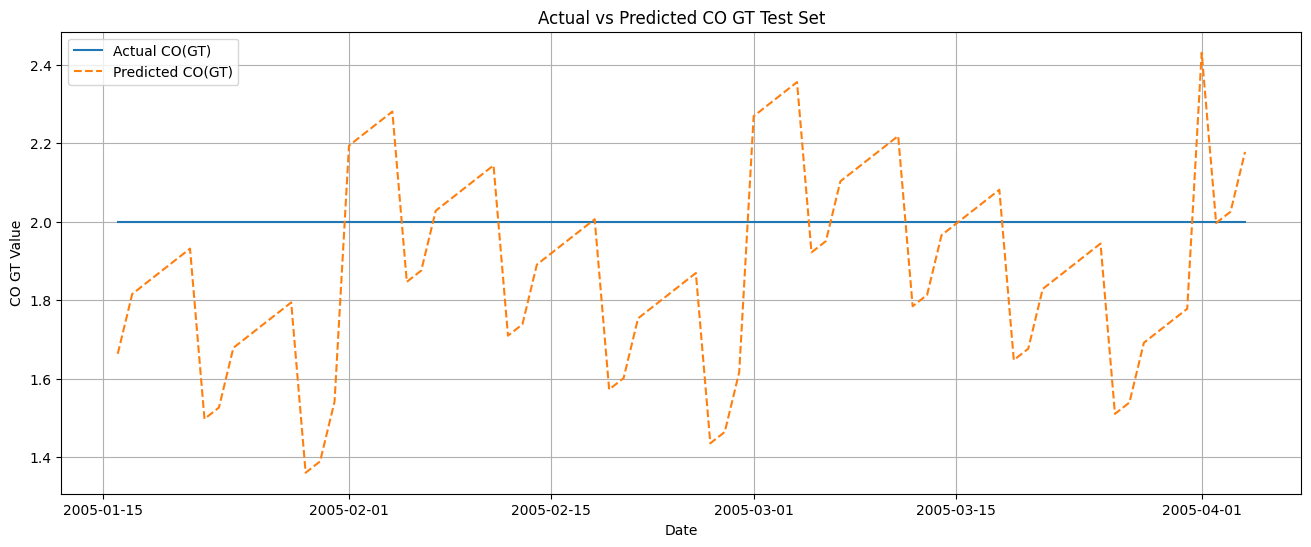

Step 4 Predictive Model Development Complete
The model is built and evaluated. The next step involves using it for real time forecasting.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# A note on prerequisites: The df_model DataFrame must be available from Step 3 (Transform Data).

print("Starting Step 4 Predictive Model Development Machine Learning")

# 1. Split Data Features and Target
print("1. Splitting data into features X and target y...")
X = df_model.drop('CO(GT)', axis=1) # Features are all columns except CO(GT)
y = df_model['CO(GT)']             # Target is CO(GT) value

print(f"Features X shape: {X.shape}")
print(f"Target y shape: {y.shape}")


# 2. Train Test Split Chronological for Time Series
# For time series it is crucial to split chronologically to avoid data leakage.
# Data is partitioned into training and testing sets.
print("2. Performing chronological train test split 80 percent train 20 percent test...")
train_size = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"X train shape: {X_train.shape}, X test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}, y test shape: {y_test.shape}")


# 3. Choose and Train a Model Linear Regression as a baseline
# Linear Regression serves as a simple interpretable baseline model.
print("3. Choosing and training a Linear Regression model...")
model = LinearRegression()
model.fit(X_train, y_train)

print("Model training complete.")


# 4. Make Predictions
print("4. Making predictions on the test set...")
y_pred = model.predict(X_test)

print("Predictions generated.")


# 5. Evaluate the Model
# Common metrics for regression models Mean Absolute Error MAE Root Mean Squared Error RMSE are calculated.
print("5. Evaluating the models performance...")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error MAE: {mae:.3f}")
print(f"Root Mean Squared Error RMSE: {rmse:.3f}")

# Optional Visualize predictions vs actuals
# A plot visually compares the model's predictions against actual values.
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test, label='Actual CO(GT)')
plt.plot(y_test.index, y_pred, label='Predicted CO(GT)', linestyle='--')
plt.title('Actual vs Predicted CO GT Test Set')
plt.xlabel('Date')
plt.ylabel('CO GT Value')
plt.legend()
plt.grid(True)
plt.show()

print("Step 4 Predictive Model Development Complete")
print("The model is built and evaluated. The next step involves using it for real time forecasting.")

## Step 5: Real-Time Data Simulation for Predictions

This phase simulates the "real-time" data flow for the dashboard. It involves generating future dates and their corresponding features for the trained model to make predictions.

In [ ]:
import pandas as pd
from datetime import timedelta
import numpy as np

# A note on prerequisites: The 'model' (trained in Step 4) and 'df_model' (from Step 3)
# must be available in the current session.

print("Starting Step 5 Real Time Data Simulation for Predictions")

# 1. Generate Future Dates
# The goal is to predict CO(GT) for the next 7 days from the end of historical data.
print("1. Generating future dates for prediction...")
last_historical_date = df_model.index.max() # Obtaining the last date from df_model
prediction_dates = pd.date_range(start=last_historical_date + timedelta(days=1), periods=7, freq='D')

print(f"Prediction dates generated: {prediction_dates.min().date()} to {prediction_dates.max().date()}")


# 2. Create Future Features
# The model requires the same features for future dates as it was trained on.
print("2. Creating future features for prediction dates...")
future_features = pd.DataFrame(index=prediction_dates)
future_features['day_of_week'] = future_features.index.dayofweek
future_features['month'] = future_features.index.month
future_features['year'] = future_features.index.year
future_features['day_of_year'] = future_features.index.dayofyear
future_features['week_of_year'] = future_features.index.isocalendar().week.astype(int)
future_features['is_weekend'] = (future_features.index.dayofweek >= 5).astype(int)

print("Future features DataFrame (first 5 rows):")
print(future_features.head())


# 3. Make Future Predictions
# The trained model from Step 4 is used to forecast CO(GT) values for these future dates.
print("3. Making future predictions...")
future_predictions = model.predict(future_features)

# A DataFrame is created to hold the future predictions.
df_future_predictions = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_CO_GT': future_predictions
})
df_future_predictions = df_future_predictions.set_index('Date')

print("Future predictions generated. First 5 predicted values:")
print(df_future_predictions.head())


print("Step 5 Real Time Data Simulation for Predictions Complete")
print("Future predictions are ready. The next step involves dashboard construction.")

Starting Step 5 Real Time Data Simulation for Predictions
1. Generating future dates for prediction...
Prediction dates generated: 2005-04-05 to 2005-04-11
2. Creating future features for prediction dates...
Future features DataFrame (first 5 rows):
            day_of_week  month  year  day_of_year  week_of_year  is_weekend
2005-04-05            1      4  2005           95            14           0
2005-04-06            2      4  2005           96            14           0
2005-04-07            3      4  2005           97            14           0
2005-04-08            4      4  2005           98            14           0
2005-04-09            5      4  2005           99            14           1
3. Making future predictions...
Future predictions generated. First 5 predicted values:
            Predicted_CO_GT
Date                       
2005-04-05         2.206643
2005-04-06         2.235520
2005-04-07         2.264397
2005-04-08         2.293274
2005-04-09         1.859730
Step 5 Rea

## Step 6: Dashboard Testing and Launch

This phase involves running the Streamlit application to visually confirm its functionality, data display, and predictions through a web interface.

In [ ]:
!pip install streamlit pyngrok --upgrade --force-reinstall --quiet
!pip install networkx==2.8.8 # Ensure networkx compatibility
!apt-get install graphviz # Ensure system-level graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.

In [ ]:
!killall streamlit
!killall ngrok

streamlit: no process found
ngrok: no process found


In [ ]:
import os
import time
from pyngrok import ngrok

# Authentication of ngrok with the provided token.
# This step needs to be performed once per Colab session.
ngrok.set_auth_token("30DzDLzHbU7gaimgih8PqfUrQYI_89BsgqqKyie4bMtU8jhvS") # The actual token is embedded here.
print("ngrok authentication complete.")

# Kill any existing Streamlit processes to ensure a clean start.
os.system("killall streamlit &")
print("Attempting to stop existing Streamlit processes.")
time.sleep(1) # Allow a moment for processes to terminate.

# Run the Streamlit application in the background and capture its output.
# The 'python -m streamlit run' command is used for execution.
# Output is redirected to 'streamlit_output.log' for diagnostic purposes.
os.system("python -m streamlit run app.py --server.port 8501 > streamlit_output.log 2>&1 &")
print("Streamlit app launch command sent. Log file will capture start up information.")

# Allow the Streamlit app sufficient time to initialize before ngrok attempts connection.
time.sleep(15) # Increased wait time to 15 seconds for robust startup.

# Obtain the public URL from ngrok.
# This action creates a secure tunnel from ngrok.io to the Streamlit app running in Colab.
try:
    public_url = ngrok.connect(addr="8501", proto="http")
    print("\nStreamlit dashboard is live at:")
    print(public_url)
    print("Click on this link to open the dashboard in a new browser tab.")
    print("This Colab cell must remain running for the dashboard to stay active.")
except Exception as e:
    print(f"\nERROR: Could not establish ngrok tunnel. Error: {e}")
    print("Information regarding the error is provided. A check of the 'streamlit_output.log' file in Colab's files panel is recommended for Streamlit errors.")
    print("Also, ensure the 'app.py' file was successfully written and contains no Python errors.")

print("\nDashboard launch attempt complete.")

ngrok authentication complete.
Attempting to stop existing Streamlit processes.
Streamlit app launch command sent. Log file will capture start up information.

Streamlit dashboard is live at:
NgrokTunnel: "https://366387b7d31c.ngrok-free.app" -> "http://localhost:8501"
Click on this link to open the dashboard in a new browser tab.
This Colab cell must remain running for the dashboard to stay active.

Dashboard launch attempt complete.
